# Fase 3: Ground Truth Generation con Campionamento Stratificato per VIN

Questo notebook genera il ground truth utilizzando un **campionamento stratificato basato su VIN** per garantire overlap sufficiente.

## Problema Risolto
Il campionamento casuale generava solo 4 VIN comuni (0.007%), insufficienti per l'evaluation.

## Soluzione: VIN-Stratified Sampling
1. Caricare dataset completi
2. Identificare TUTTI i VIN comuni
3. Campionare preferenzialmente record con VIN comuni
4. Target: **50-100 match pairs** (0.1-0.2% overlap)
5. Riempire con campioni casuali
6. Generare ground truth sui campioni stratificati

## Obiettivi
- **Craigslist**: 10,000 record (inclusi record con VIN comuni)
- **UsedCars**: 50,000 record (inclusi record con VIN comuni)
- **Match pair target**: 50-100 coppie
- **Split**: 70% train, 10% validation, 20% test

## 1. Import Librerie

In [1]:
import sys
import os

# Aggiungi il percorso della cartella src al PYTHONPATH
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
sys.path.append(os.path.abspath('..'))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import moduli personalizzati
from src.ground_truth import GroundTruthGenerator

# Imposta stile grafici
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Librerie importate con successo!")

✓ Librerie importate con successo!


## 2. Caricamento Dataset Completi

In [3]:
# Percorsi dei dataset allineati
craigslist_path = '../data/processed/craigslist_aligned.csv'
usedcars_path = '../data/processed/usedcars_aligned.csv'

# Carica i dataset COMPLETI
print("Caricamento dataset completi...")
df_craigslist_full = pd.read_csv(craigslist_path, low_memory=False)
print(f"✓ Craigslist: {len(df_craigslist_full):,} righe, {len(df_craigslist_full.columns)} colonne")

df_usedcars_full = pd.read_csv(usedcars_path, low_memory=False)
print(f"✓ US Used Cars: {len(df_usedcars_full):,} righe, {len(df_usedcars_full.columns)} colonne")

Caricamento dataset completi...
✓ Craigslist: 426,880 righe, 17 colonne
✓ US Used Cars: 3,000,040 righe, 14 colonne


## 3. Identificazione VIN Comuni nei Dataset Completi

In [4]:
# Filtra VIN validi (lunghezza >= 11)
print("Analisi VIN nei dataset completi...")

# Craigslist VIN validi
craigslist_valid_vin = df_craigslist_full[
    df_craigslist_full['vin'].notna() & 
    (df_craigslist_full['vin'].str.len() >= 11)
].copy()

# UsedCars VIN validi
usedcars_valid_vin = df_usedcars_full[
    df_usedcars_full['vin'].notna() & 
    (df_usedcars_full['vin'].str.len() >= 11)
].copy()

print(f"\nCraigslist VIN validi: {len(craigslist_valid_vin):,} / {len(df_craigslist_full):,}")
print(f"UsedCars VIN validi: {len(usedcars_valid_vin):,} / {len(df_usedcars_full):,}")

Analisi VIN nei dataset completi...

Craigslist VIN validi: 265,350 / 426,880
UsedCars VIN validi: 2,998,734 / 3,000,040


In [5]:
# Trova VIN comuni
vins_craigslist = set(craigslist_valid_vin['vin'].unique())
vins_usedcars = set(usedcars_valid_vin['vin'].unique())

common_vins = vins_craigslist & vins_usedcars

print("\nVIN COMUNI NEI DATASET COMPLETI:")
print("=" * 80)
print(f"VIN unici in Craigslist: {len(vins_craigslist):,}")
print(f"VIN unici in UsedCars: {len(vins_usedcars):,}")
print(f"VIN comuni: {len(common_vins):,}")

if len(common_vins) == 0:
    print("\n ATTENZIONE: Nessun VIN comune trovato!")
    print("Il campionamento stratificato non può essere applicato.")
else:
    print(f"\n✓ Trovati {len(common_vins):,} VIN comuni per il campionamento stratificato")


VIN COMUNI NEI DATASET COMPLETI:
VIN unici in Craigslist: 117,893
VIN unici in UsedCars: 2,998,694
VIN comuni: 3,955

✓ Trovati 3,955 VIN comuni per il campionamento stratificato


## 4. Campionamento Stratificato per VIN

Strategia:
1. Selezionare TUTTI i record con VIN comuni
2. Se superano la dimensione target, campionare casualmente
3. Riempire con record casuali fino alla dimensione desiderata

In [6]:
# Parametri campionamento
SAMPLE_SIZE_CRAIGSLIST = 10000
SAMPLE_SIZE_USEDCARS = 50000
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

print("\nCAMPIONAMENTO STRATIFICATO PER VIN:")
print("=" * 80)


CAMPIONAMENTO STRATIFICATO PER VIN:


In [7]:
# ========== CRAIGSLIST STRATIFIED SAMPLING ==========

# Step 1: Record con VIN comuni
craigslist_with_common_vin = craigslist_valid_vin[
    craigslist_valid_vin['vin'].isin(common_vins)
].copy()

print("\nCraigslist:")
print(f"  Record con VIN comuni: {len(craigslist_with_common_vin):,}")

# Step 2: Campiona o prendi tutti
if len(craigslist_with_common_vin) >= SAMPLE_SIZE_CRAIGSLIST:
    # Troppi record con VIN comuni, campiona
    df_craigslist = craigslist_with_common_vin.sample(
        n=SAMPLE_SIZE_CRAIGSLIST, 
        random_state=RANDOM_SEED
    )
    print(f"  → Campionati {SAMPLE_SIZE_CRAIGSLIST:,} da record con VIN comuni")
else:
    # Prendi tutti i record con VIN comuni
    df_craigslist = craigslist_with_common_vin.copy()
    
    # Step 3: Riempi con record casuali
    remaining_size = SAMPLE_SIZE_CRAIGSLIST - len(df_craigslist)
    
    if remaining_size > 0:
        # Record senza VIN comuni
        craigslist_without_common_vin = df_craigslist_full[
            ~df_craigslist_full.index.isin(craigslist_with_common_vin.index)
        ]
        
        # Campiona record casuali
        random_sample = craigslist_without_common_vin.sample(
            n=min(remaining_size, len(craigslist_without_common_vin)),
            random_state=RANDOM_SEED
        )
        
        df_craigslist = pd.concat([df_craigslist, random_sample], ignore_index=False)
        
        print(f"  → Presi tutti {len(craigslist_with_common_vin):,} record con VIN comuni")
        print(f"  → Aggiunti {len(random_sample):,} record casuali")

print(f"  ✓ Totale Craigslist sample: {len(df_craigslist):,}")


Craigslist:
  Record con VIN comuni: 9,147
  → Presi tutti 9,147 record con VIN comuni
  → Aggiunti 853 record casuali
  ✓ Totale Craigslist sample: 10,000


In [8]:
# ========== USEDCARS STRATIFIED SAMPLING ==========

# Step 1: Record con VIN comuni
usedcars_with_common_vin = usedcars_valid_vin[
    usedcars_valid_vin['vin'].isin(common_vins)
].copy()

print("\nUsedCars:")
print(f"  Record con VIN comuni: {len(usedcars_with_common_vin):,}")

# Step 2: Campiona o prendi tutti
if len(usedcars_with_common_vin) >= SAMPLE_SIZE_USEDCARS:
    # Troppi record con VIN comuni, campiona
    df_usedcars = usedcars_with_common_vin.sample(
        n=SAMPLE_SIZE_USEDCARS, 
        random_state=RANDOM_SEED
    )
    print(f"  → Campionati {SAMPLE_SIZE_USEDCARS:,} da record con VIN comuni")
else:
    # Prendi tutti i record con VIN comuni
    df_usedcars = usedcars_with_common_vin.copy()
    
    # Step 3: Riempi con record casuali
    remaining_size = SAMPLE_SIZE_USEDCARS - len(df_usedcars)
    
    if remaining_size > 0:
        # Record senza VIN comuni
        usedcars_without_common_vin = df_usedcars_full[
            ~df_usedcars_full.index.isin(usedcars_with_common_vin.index)
        ]
        
        # Campiona record casuali
        random_sample = usedcars_without_common_vin.sample(
            n=min(remaining_size, len(usedcars_without_common_vin)),
            random_state=RANDOM_SEED
        )
        
        df_usedcars = pd.concat([df_usedcars, random_sample], ignore_index=False)
        
        print(f"  → Presi tutti {len(usedcars_with_common_vin):,} record con VIN comuni")
        print(f"  → Aggiunti {len(random_sample):,} record casuali")

print(f"  ✓ Totale UsedCars sample: {len(df_usedcars):,}")


UsedCars:
  Record con VIN comuni: 3,955
  → Presi tutti 3,955 record con VIN comuni
  → Aggiunti 46,045 record casuali
  ✓ Totale UsedCars sample: 50,000


In [9]:
# Verifica VIN comuni nel sample
sample_vins_craigslist = set(df_craigslist[df_craigslist['vin'].notna()]['vin'])
sample_vins_usedcars = set(df_usedcars[df_usedcars['vin'].notna()]['vin'])
sample_common_vins = sample_vins_craigslist & sample_vins_usedcars

print("\nVIN COMUNI NEL CAMPIONE:")
print("=" * 80)
print(f"VIN comuni: {len(sample_common_vins):,}")
print(f"Match pairs attesi: ~{len(sample_common_vins):,}")
print(f"Percentuale overlap: {len(sample_common_vins) / (SAMPLE_SIZE_CRAIGSLIST + SAMPLE_SIZE_USEDCARS) * 100:.3f}%")

if len(sample_common_vins) < 50:
    print(f"\n ATTENZIONE: Overlap insufficiente ({len(sample_common_vins)} < 50)")
    print("Consiglio: aumentare dimensione campione o verificare VIN comuni disponibili")
else:
    print(f"\n✓ Overlap sufficiente: {len(sample_common_vins):,} VIN comuni")


VIN COMUNI NEL CAMPIONE:
VIN comuni: 3,955
Match pairs attesi: ~3,955
Percentuale overlap: 6.592%

✓ Overlap sufficiente: 3,955 VIN comuni


## 5. Reset Indici e Generazione record_id

IMPORTANTE: Reset indici per evitare problemi con il GroundTruthGenerator

In [10]:
# Reset indici per avere indici sequenziali 0, 1, 2, ...
print("\nReset indici e generazione record_id...")

df_craigslist = df_craigslist.reset_index(drop=True)
df_usedcars = df_usedcars.reset_index(drop=True)

# Genera record_id in formato df1_XXX e df2_XXX
# Questo DEVE corrispondere a ciò che GroundTruthGenerator fa internamente
df_craigslist['record_id'] = ['df1_' + str(i) for i in range(len(df_craigslist))]
df_usedcars['record_id'] = ['df2_' + str(i) for i in range(len(df_usedcars))]

print("✓ Indici resettati")
print(f"✓ record_id generati: df1_0 ... df1_{len(df_craigslist)-1}")
print(f"✓ record_id generati: df2_0 ... df2_{len(df_usedcars)-1}")


Reset indici e generazione record_id...
✓ Indici resettati
✓ record_id generati: df1_0 ... df1_9999
✓ record_id generati: df2_0 ... df2_49999


## 6. Generazione Ground Truth

In [11]:
# Crea generatore di ground truth
print("\nCreazione generatore ground truth...")
gt_generator = GroundTruthGenerator(
    df1=df_craigslist,
    df2=df_usedcars,
    vin_column='vin',
    min_vin_length=11
)
print("✓ Generatore creato")


Creazione generatore ground truth...
✓ Generatore creato


In [12]:
# Trova match basati su VIN
print("\nRicerca match basati su VIN...")
matches = gt_generator.find_matches()

print(f"\n✓ Match trovati: {len(matches):,}")
print("\nCampione di match:")
display(matches.head(10))


Ricerca match basati su VIN...
Pulizia VIN in corso...
DF1: 10000 -> 4472 record con VIN validi
DF2: 50000 -> 49974 record con VIN validi
VIN comuni trovati: 3955
Coppie di match generate: 3955

✓ Match trovati: 3,955

Campione di match:


,record_id_1,record_id_2,vin,label
0,df1_379,df2_2745,1G1JC6SG0F4112896,1
1,df1_4457,df2_1205,1C3CDZAB2CN286337,1
2,df1_2825,df2_1703,1G1PC5SB0E7302901,1
3,df1_655,df2_3799,19UUB1F35HA004877,1
4,df1_5967,df2_417,1G1ZB5STXJF104590,1
5,df1_6256,df2_225,1HGCG56611A119769,1
6,df1_8618,df2_1003,JN1BJ1CP2KW222952,1
7,df1_2651,df2_1758,5UXFE4C57AL278113,1
8,df1_696,df2_3859,1GTW7FCA0C1140898,1
9,df1_335,df2_2920,3MZBN1L3XHM151293,1


In [13]:
# Genera non-match
print("\nGenerazione non-match...")
non_matches = gt_generator.generate_non_matches(
    ratio=1.0  # Stesso numero di match (ratio 1:1)
)

print(f"\n✓ Non-match generati: {len(non_matches):,}")
print("\nCampione di non-match:")
display(non_matches.head(10))


Generazione non-match...
Pulizia VIN in corso...
DF1: 10000 -> 4472 record con VIN validi
DF2: 50000 -> 49974 record con VIN validi
Generazione di 3955 non-match...
Non-match generati: 3955

✓ Non-match generati: 3,955

Campione di non-match:


,record_id_1,record_id_2,vin_1,vin_2,label
0,df1_4949,df2_32144,ZASPAKBN5L7C75527,1HGCV1F30JA078152,0
1,df1_502,df2_43041,5NPE24AFXFH020794,JF2SKAEC7KH459673,0
2,df1_5446,df2_27958,3N1AB7AP3JY239281,5J6YH28789L001928,0
3,df1_4139,df2_46347,2GNFLEEK2H6326935,5N1AZ2MG4JN169208,0
4,df1_8939,df2_24158,1GAZGPFG6H1199893,WP1AA2A55LLB06534,0
5,df1_3384,df2_49595,3C4PDDEG0KT739410,3VW5T7BU5LM080660,0
6,df1_6173,df2_7367,KNDPCCA22D7392600,KL4CJASB7LB319946,0
7,df1_2615,df2_31608,W04GM6SX1K1048212,1G6DU5RK3L0148433,0
8,df1_9588,df2_2177,5UXTR9C56KLE15390,1G1ZD5ST2LF002620,0
9,df1_3170,df2_37544,1GCUHAD41A1173597,2GNAXUEV6L6254407,0


In [14]:
# Crea ground truth completo
ground_truth = gt_generator.create_ground_truth()

print("\nGROUND TRUTH COMPLETO:")
print("=" * 80)
print(f"Totale coppie: {len(ground_truth):,}")
print("\nDistribuzione label:")
print(ground_truth['label'].value_counts())
print(f"\nPercentuale match: {(ground_truth['label'].sum() / len(ground_truth) * 100):.2f}%")

print("\nCampione ground truth:")
display(ground_truth.head(10))

Ground truth totale: 7910 coppie
  - Match: 3955
  - Non-match: 3955

GROUND TRUTH COMPLETO:
Totale coppie: 7,910

Distribuzione label:
label
1    3955
0    3955
Name: count, dtype: int64

Percentuale match: 50.00%

Campione ground truth:


,record_id_1,record_id_2,vin,label,vin_1,vin_2,price_1,price_2,year_1,year_2,...,size_1,size_2,type_1,type_2,paint_color_1,paint_color_2,state_1,state_2,description_1,description_2
0,df1_4627,df2_1070,1FMCU0GD5HUD84223,1,NaN,NaN,18500.0,18000.0,2017.0,2017,...,NaN,None,NaN,SUV / Crossover,red,Ruby Red Metallic Tinted Clearcoat,mi,None,The Carfax shows no accidents or damage report...,[!@@Additional Info@@!]1.5L 4 Cylinder Engine ...
1,df1_7235,df2_26915,NaN,0,2G1WG5E38D1211567,WDZPE7CC2D5786861,7777.0,21499.0,2013.0,2013,...,full-size,None,sedan,Van,white,GRAY,or,None,K and S Auto Wholesale 503-581-2277 2095 fairg...,[!@@Additional Info@@!]Air Conditioning; Power...
2,df1_9438,df2_45886,NaN,0,1FVACWDT5FHGH8100,3GNAXSEV7JL111673,55990.0,23500.0,2015.0,2018,...,NaN,None,NaN,SUV / Crossover,white,Storm Blue Metallic,ny,None,2015 Freightliner M2 106 Medium Duty 21' ROLL ...,[!@@Additional Info@@!]Confidence & Convenienc...
3,df1_4441,df2_338,2HKRM4H50EH609201,1,NaN,NaN,12778.0,14595.0,2014.0,2014,...,NaN,None,SUV,SUV / Crossover,NaN,Alabaster Silver Metallic,ma,None,Lundgren Honda address: 163 Washington Str...,Recent Arrival![!@@Additional Info@@!]6 Speake...
4,df1_5551,df2_1141,1C3LC66M37N630162,1,NaN,NaN,3995.0,3995.0,2007.0,2007,...,NaN,None,sedan,Sedan,white,White,nc,None,2007 Chrysler Sebring Limited 4dr Sedan Of...,!!!!!2007 CHRYSLER SEBRING!!!! -AUTOMATIC -S...
5,df1_5976,df2_47554,NaN,0,1C4PJMAK7CW139529,1FTRX145X6FA36220,12999.0,14950.0,2012.0,2006,...,NaN,None,SUV,Pickup Truck,silver,Black,nj,None,Ready To Upgrade Your Ride Today? We Make It F...,2006 Harley Davidson F-150 Extended Cab** 5.4 ...
6,df1_8877,df2_1406,5J6RM4H56CL012346,1,NaN,NaN,9995.0,10995.0,2012.0,2012,...,NaN,None,NaN,SUV / Crossover,green,Opal Sage Metallic,wi,None,Bennetts Auto Inc address: W8136 Winnegamie...,Bennetts Auto is a family owned business for o...
7,df1_3019,df2_33682,NaN,0,3GNDA23P76S576308,1FMCU9GD9HUA05714,4995.0,16500.0,2006.0,2017,...,sub-compact,None,wagon,SUV / Crossover,grey,White,id,None,2006 CHEVROLET HHR LT!!! 93K MILES!!! LEATHER ...,*2017 FORD ESCAPE SE AWD!* *NEW TIRES!* *NEW R...
8,df1_5738,df2_3742,WAUB4AF45KA109884,1,NaN,NaN,46995.0,60640.0,2019.0,2019,...,NaN,None,NaN,Sedan,NaN,NaN,nj,None,2019 Audi S4 CALL Automotive Avenues: (732) 44...,The 2019 Audi S4 isnt just ahead of the curve....
9,df1_767,df2_3922,1FD8X3G61CEC56743,1,NaN,NaN,29990.0,29990.0,2012.0,2012,...,NaN,None,other,NaN,white,WHITE,ca,None,2012 FORD F350 SUPER DUTY Offered by: RT M...,2012 FORD F-350 F350 UTILTY COVERED WALK-IN DU...


## 7. Visualizzazioni

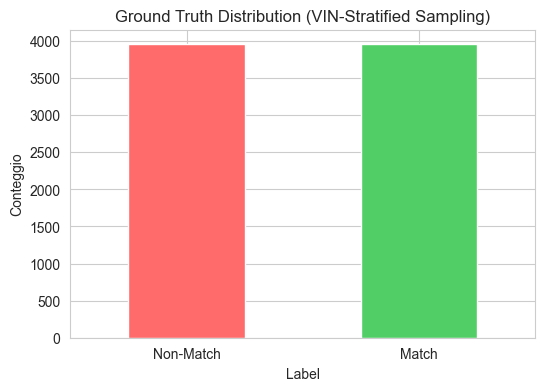

In [15]:
# Grafico distribuzione
fig, ax = plt.subplots(figsize=(6, 4))
ground_truth['label'].value_counts().plot(
    kind='bar', 
    ax=ax, 
    color=['#ff6b6b', '#51cf66']
)
ax.set_xlabel('Label')
ax.set_ylabel('Conteggio')
ax.set_title('Ground Truth Distribution (VIN-Stratified Sampling)')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Non-Match', 'Match'], rotation=0)
plt.savefig('../results/visualizations/ground_truth_distribution_stratified.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Split Train/Validation/Test

In [16]:
# Split del ground truth
print("\nCreazione split train/validation/test...")

train, validation, test = gt_generator.split_ground_truth(
    ground_truth=ground_truth,
    test_size=0.2,
    val_size=0.1,
    random_state=42
)

print("\nSTATISTICHE SPLIT:")
print("=" * 80)
print(f"Training set:   {len(train):,} coppie ({len(train)/len(ground_truth)*100:.1f}%)")
print(f"  - Match:      {train['label'].sum():,}")
print(f"  - Non-match:  {len(train) - train['label'].sum():,}")

print(f"\nValidation set: {len(validation):,} coppie ({len(validation)/len(ground_truth)*100:.1f}%)")
print(f"  - Match:      {validation['label'].sum():,}")
print(f"  - Non-match:  {len(validation) - validation['label'].sum():,}")

print(f"\nTest set:       {len(test):,} coppie ({len(test)/len(ground_truth)*100:.1f}%)")
print(f"  - Match:      {test['label'].sum():,}")
print(f"  - Non-match:  {len(test) - test['label'].sum():,}")


Creazione split train/validation/test...
Split completato:
  - Training: 5537 (70.0%)
  - Validation: 791 (10.0%)
  - Test: 1582 (20.0%)

STATISTICHE SPLIT:
Training set:   5,537 coppie (70.0%)
  - Match:      2,769
  - Non-match:  2,768

Validation set: 791 coppie (10.0%)
  - Match:      395
  - Non-match:  396

Test set:       1,582 coppie (20.0%)
  - Match:      791
  - Non-match:  791


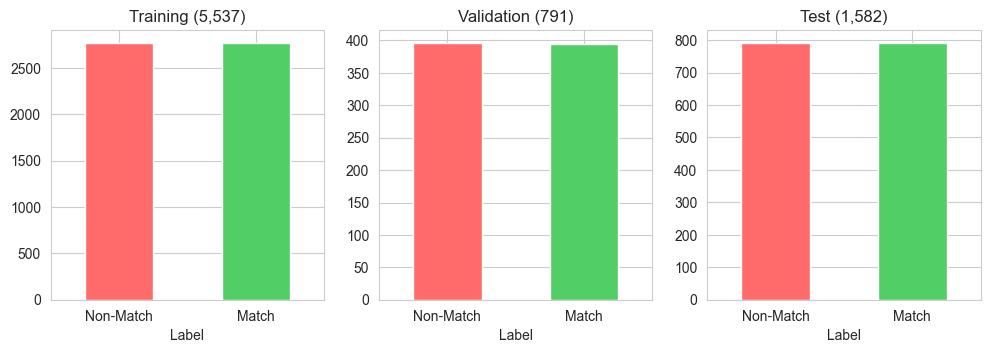

In [17]:
# Visualizza distribuzione split
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))

for idx, (data, name) in enumerate([(train, 'Training'), (validation, 'Validation'), (test, 'Test')]):
    data['label'].value_counts().plot(
        kind='bar', 
        ax=axes[idx], 
        color=['#ff6b6b', '#51cf66']
    )
    axes[idx].set_title(f'{name} ({len(data):,})')
    axes[idx].set_xlabel('Label')
    axes[idx].set_xticks([0, 1])
    axes[idx].set_xticklabels(['Non-Match', 'Match'], rotation=0)

plt.savefig('../results/visualizations/ground_truth_splits_stratified.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Salvataggio Ground Truth e Dataset Campionati

In [18]:
# Crea directory se non esiste
os.makedirs('../data/ground_truth', exist_ok=True)

# Salva i file ground truth
print("\nSalvataggio ground truth...")

train.to_csv('../data/ground_truth/train.csv', index=False)
print(f"✓ Training salvato: data/ground_truth/train.csv ({len(train):,} coppie)")

validation.to_csv('../data/ground_truth/validation.csv', index=False)
print(f"✓ Validation salvato: data/ground_truth/validation.csv ({len(validation):,} coppie)")

test.to_csv('../data/ground_truth/test.csv', index=False)
print(f"✓ Test salvato: data/ground_truth/test.csv ({len(test):,} coppie)")

ground_truth.to_csv('../data/ground_truth/ground_truth_full.csv', index=False)
print(f"✓ Ground truth completo salvato: data/ground_truth/ground_truth_full.csv ({len(ground_truth):,} coppie)")


Salvataggio ground truth...
✓ Training salvato: data/ground_truth/train.csv (5,537 coppie)
✓ Validation salvato: data/ground_truth/validation.csv (791 coppie)
✓ Test salvato: data/ground_truth/test.csv (1,582 coppie)
✓ Ground truth completo salvato: data/ground_truth/ground_truth_full.csv (7,910 coppie)


In [19]:
# Salva anche i dataset campionati per uso nelle fasi successive
print("\nSalvataggio dataset campionati...")

df_craigslist.to_csv('../data/processed/craigslist_sample.csv', index=False)
print(f"✓ Craigslist sample salvato: data/processed/craigslist_sample.csv ({len(df_craigslist):,} records)")

df_usedcars.to_csv('../data/processed/usedcars_sample.csv', index=False)
print(f"✓ UsedCars sample salvato: data/processed/usedcars_sample.csv ({len(df_usedcars):,} records)")

print("\n" + "="*80)
print("FASE 3 COMPLETATA CON SUCCESSO!")
print("="*80)
print(f"\n✓ Ground truth con {len(ground_truth):,} coppie ({ground_truth['label'].sum():,} match)")
print("✓ Dataset campionati salvati con record_id corretti (df1_XXX, df2_XXX)")
print("✓ Campionamento stratificato per VIN applicato")
print("\nProssimi passi:")
print("  → Fase 4: Rieseguire blocking strategies sui nuovi campioni")
print("  → Fase 5: Rieseguire record linkage per ottenere metriche significative")


Salvataggio dataset campionati...
✓ Craigslist sample salvato: data/processed/craigslist_sample.csv (10,000 records)
✓ UsedCars sample salvato: data/processed/usedcars_sample.csv (50,000 records)

FASE 3 COMPLETATA CON SUCCESSO!

✓ Ground truth con 7,910 coppie (3,955 match)
✓ Dataset campionati salvati con record_id corretti (df1_XXX, df2_XXX)
✓ Campionamento stratificato per VIN applicato

Prossimi passi:
  → Fase 4: Rieseguire blocking strategies sui nuovi campioni
  → Fase 5: Rieseguire record linkage per ottenere metriche significative


## 10. Report Finale

In [20]:
# Genera report
report = f"""GROUND TRUTH GENERATION REPORT (VIN-Stratified Sampling)
{'='*80}

DATASET COMPLETI:
  - Craigslist totale: {len(df_craigslist_full):,} record
  - UsedCars totale: {len(df_usedcars_full):,} record
  - VIN comuni disponibili: {len(common_vins):,}

CAMPIONAMENTO STRATIFICATO:
  - Craigslist sample: {len(df_craigslist):,} record
  - UsedCars sample: {len(df_usedcars):,} record
  - VIN comuni nel sample: {len(sample_common_vins):,}
  - Overlap percentage: {len(sample_common_vins) / (len(df_craigslist) + len(df_usedcars)) * 100:.3f}%

GROUND TRUTH:
  - Totale coppie: {len(ground_truth):,}
  - Match: {ground_truth['label'].sum():,}
  - Non-match: {(1-ground_truth['label']).sum():,}
  - Match percentage: {ground_truth['label'].mean()*100:.2f}%

SPLITS:
  - Training: {len(train):,} coppie ({train['label'].sum():,} match)
  - Validation: {len(validation):,} coppie ({validation['label'].sum():,} match)
  - Test: {len(test):,} coppie ({test['label'].sum():,} match)

FILES GENERATI:
  ✓ data/ground_truth/train.csv
  ✓ data/ground_truth/validation.csv
  ✓ data/ground_truth/test.csv
  ✓ data/ground_truth/ground_truth_full.csv
  ✓ data/processed/craigslist_sample.csv
  ✓ data/processed/usedcars_sample.csv

NOTE:
  - Campionamento stratificato applicato per massimizzare VIN overlap
  - record_id formato: df1_XXX (Craigslist), df2_XXX (UsedCars)
  - I dataset campionati DEVONO essere usati nelle Fasi 4 e 5
  - Ground truth e campioni ora allineati correttamente
"""

print(report)

# Salva report
with open('../results/ground_truth_report_stratified.txt', 'w', encoding='utf-8') as f:
    f.write(report)
    
print("✓ Report salvato: results/ground_truth_report_stratified.txt")

GROUND TRUTH GENERATION REPORT (VIN-Stratified Sampling)

DATASET COMPLETI:
  - Craigslist totale: 426,880 record
  - UsedCars totale: 3,000,040 record
  - VIN comuni disponibili: 3,955

CAMPIONAMENTO STRATIFICATO:
  - Craigslist sample: 10,000 record
  - UsedCars sample: 50,000 record
  - VIN comuni nel sample: 3,955
  - Overlap percentage: 6.592%

GROUND TRUTH:
  - Totale coppie: 7,910
  - Match: 3,955
  - Non-match: 3,955
  - Match percentage: 50.00%

SPLITS:
  - Training: 5,537 coppie (2,769 match)
  - Validation: 791 coppie (395 match)
  - Test: 1,582 coppie (791 match)

FILES GENERATI:
  ✓ data/ground_truth/train.csv
  ✓ data/ground_truth/validation.csv
  ✓ data/ground_truth/test.csv
  ✓ data/ground_truth/ground_truth_full.csv
  ✓ data/processed/craigslist_sample.csv
  ✓ data/processed/usedcars_sample.csv

NOTE:
  - Campionamento stratificato applicato per massimizzare VIN overlap
  - record_id formato: df1_XXX (Craigslist), df2_XXX (UsedCars)
  - I dataset campionati DEVONO esse